<a href="https://colab.research.google.com/github/GiuliaPaggi/JetIDwithAutoencoder/blob/main/JetIDAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import keras

from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

from IPython.utils.py3compat import no_code

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

Define layers input dimensions

In [ ]:
n_chann = 98
layer = 8
n_input = (n_chann*layer)+2 #len of vector
n_hidden1 = int(n_input/2)
n_code = int(n_hidden1/2) #codings
n_hidden2 = n_hidden1
n_output = n_input


In [ ]:
train_ae = False

Import shower data from drive

In [ ]:
os.chdir('/content/drive/MyDrive/JetDTsAutoencoder/data/')
csv_files_shower = [f for f in os.listdir() if (f.startswith('shower') and f.endswith('.csv'))]
dfs = []

for data_file in csv_files_shower :
  print("Read "+data_file)
  s_df = pd.read_csv(data_file)
  dfs.append(s_df)

df = pd.concat(dfs, ignore_index = True)

df = df.drop(columns= 'Unnamed: 0')
df = df.sample(frac = 1).reset_index(drop=True)
del(dfs)


Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_8.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_23.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_1.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_10.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_20.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_4.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_14.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_0.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_7.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_13.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_15.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_26.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_22.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_24.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_18.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_19.csv
Read shower_HiddenGluGluH_mH-375_Phi-60_ctau-1000_27.csv
Read shower_HiddenGluGluH_mH-375_Phi

split in train, validation and test samples -> remove validation, use validation_split attribute of training method

In [ ]:
print(df.iloc[:10, :(n_input-2)])

   ch1l1  ch1l2  ch1l3  ch1l4  ch1l5  ch1l6  ch1l7  ch1l8  ch2l1  ch2l2  ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   
5      0      0      0      0      0      0      0      0      0      0  ...   
6      0      0      0      0      0      0      0      0      0      0  ...   
7      0      0      0      0      0      0      0      0      0      0  ...   
8      0      0      0      0      0      0      0      0      0      0  ...   
9      0      0      0      0      0      0      0      0      0      0  ...   

   ch97l7  ch97l8  ch98l1  ch98l2  ch98l3  ch98l4  ch98l5  ch98l6  ch98l7  \
0       0       0       0       0       0 

Divide in train - validation - test

In [ ]:
if train_ae :
  train_events = round(len(df)*.7)
  validation_events = round(len(df)*.2)
  test_events = len(df)-(train_events+validation_events)

  x_train = df.iloc[:train_events, :n_input]
  x_validation = df.iloc[train_events:(train_events+validation_events), :n_input]
  x_test = df.iloc[(train_events+validation_events):, :n_input]

  y_train = df.iloc[:train_events, n_input:]
  y_validation = df.iloc[train_events:(train_events+validation_events), n_input:]
  y_test = df.iloc[(train_events+validation_events):, n_input:]


Check the correct division in train - validation - test samples

In [ ]:
if train_ae :
  print(len(df))
  print("train sample")
  print(train_events)
  print(len(x_train))
  print("validation sample")
  print(validation_events)
  print(len(x_validation))
  print("test sample")
  print(len(x_test))


In [ ]:
if train_ae :
  len(x_train.to_numpy()[0])

Define plotting functions

In [ ]:
def plot_input(sample, n, dims):
    # number of example to show
    plt.figure(figsize=(80, 36))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        event = np.random.randint(0, (layer*n_chann)+1)
        print(event)
        digi = n_input-2
        plt.imshow(sample.iloc[event, :digi].to_numpy().reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

    plt.show()

def plot_autoencoder_outputs(sample, autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(sample)

    # number of example digits to show
    plt.figure(figsize=(8, 6))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        event = np.random.randint(0, (layer*n_chann)+1)
        print(event)
        plt.imshow(sample.iloc[i, :-2].to_numpy().reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i,:-2].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])

Check the input images

568


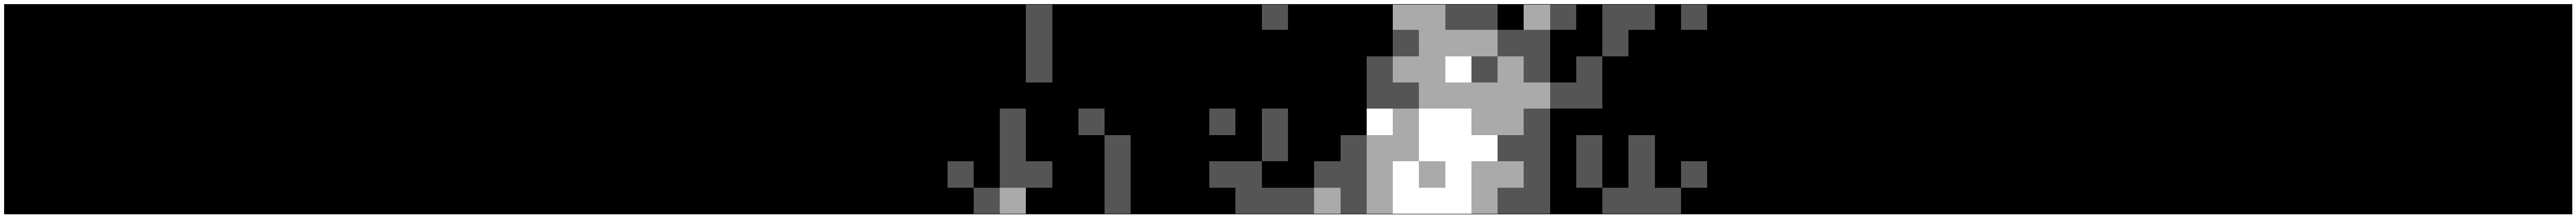

In [ ]:
plot_input(df, 1, (layer, n_chann))

In [ ]:
if train_ae :
  print(x_train.shape[1])

Define the autoencoder model

In [ ]:
input_img = n_input
#define separately encoder and decoder to extract encoder for classification after training
encoder = models.Sequential([
    layers.InputLayer(input_shape=(input_img,)),
    layers.Dense(n_hidden1, activation='relu'),
    layers.Dense(n_code, activation='relu'),
])

# Decoder
decoder = models.Sequential([
    layers.Dense(n_hidden1, activation='relu', input_shape=(n_code,)),
    layers.Dense(input_img, activation='sigmoid'),
])

# Autoencoder
autoencoder = models.Sequential([
    encoder,
    decoder,
])

l_rate = 0.001 # 0.001 default value

#schedule learning rate to change
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.99)

schedule = keras.callbacks.LearningRateScheduler(lr_scheduler)
#implement early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True, mode = 'min')

autoencoder.compile(optimizer='adam', loss='MSE')


Check the autoencoder model

In [ ]:
if train_ae:
  autoencoder.summary()

In [ ]:
if train_ae :
  n_epochs = 250
  tf.keras.backend.clear_session()
  tf.random.set_seed(42)

  history = autoencoder.fit(x_train, x_train, batch_size= 512, epochs=n_epochs, validation_data=(x_validation, x_validation), callbacks=[schedule, early_stop])

Plot train and validation loss during the training to check for convergence/overfitting

In [ ]:
if train_ae :
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(204)
  plt.figure()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

save the model after training

In [ ]:
if train_ae :
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
if train_ae :
  autoencoder.save_weights('/content/drive/MyDrive/JetDTsAutoencoder')

load previously saved weights so there is no need to train every time

In [ ]:
autoencoder.load_weights('/content/drive/MyDrive/JetDTsAutoencoder')

In [ ]:
if train_ae:
  test_eval = autoencoder.evaluate(x_test, x_test)

In [ ]:
if train_ae:
  plot_autoencoder_outputs(x_validation, autoencoder, 2, (layer, n_chann))

Use the trained model encoder part for classification

Import the muon data and add them to the dataset, shuffle

In [ ]:
#add muons to the dataset

df["is_muon"] = 0

dfs = []
csv_files_muon = [f for f in os.listdir() if (f.startswith('muon') and f.endswith('.csv'))]
for data_file in csv_files_muon :
  print("Read "+data_file)
  m_df = pd.read_csv(data_file)
  m_df["is_muon"] = 1
  dfs.append(m_df)


c_df = pd.concat(dfs, ignore_index = True)
del(dfs)
c_df = c_df.drop(columns = 'Unnamed: 0')

c_df = pd.concat([c_df, df], ignore_index=True)
c_df = c_df.sample(frac = 1).reset_index(drop=True)


Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_7.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_26.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_11.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_30.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_22.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_9.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_15.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_28.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_6.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_23.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_29.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_25.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_17.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_19.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_5.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_1.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_8.csv
Read muon_HiddenGluGluH_mH-375_Phi-60_ctau-1000_20.csv
Read muon_Hidden

Divide also the new dataset in train validation and test subsample

In [ ]:
print(len(c_df))
classification_train_events = round(len(c_df)*.7)
classification_validation_events = round(len(c_df)*.2)
classification_test_events = len(c_df)-(classification_train_events+classification_validation_events)

c_x_train = c_df.iloc[:classification_train_events , :n_input]
c_x_validation = c_df.iloc[classification_train_events:(classification_train_events+classification_validation_events) , :n_input]
c_x_test = c_df.iloc[(classification_train_events+classification_validation_events): , :n_input]

c_y_train = c_df.iloc[:classification_train_events, n_input:]
c_y_validation = c_df.iloc[classification_train_events:(classification_train_events+classification_validation_events), n_input:]
c_y_test = c_df.iloc[(classification_train_events+classification_validation_events):, n_input:]

295000


In [ ]:
  print(len(c_df))
  print("train sample")
  print(classification_train_events)
  print(len(c_x_train))
  print("validation sample")
  print(classification_validation_events)
  print(len(c_x_validation))
  print("test sample")
  print(len(c_x_test))

295000
train sample
206500
206500
validation sample
59000
59000
test sample
29500


Check the images also with muons

203


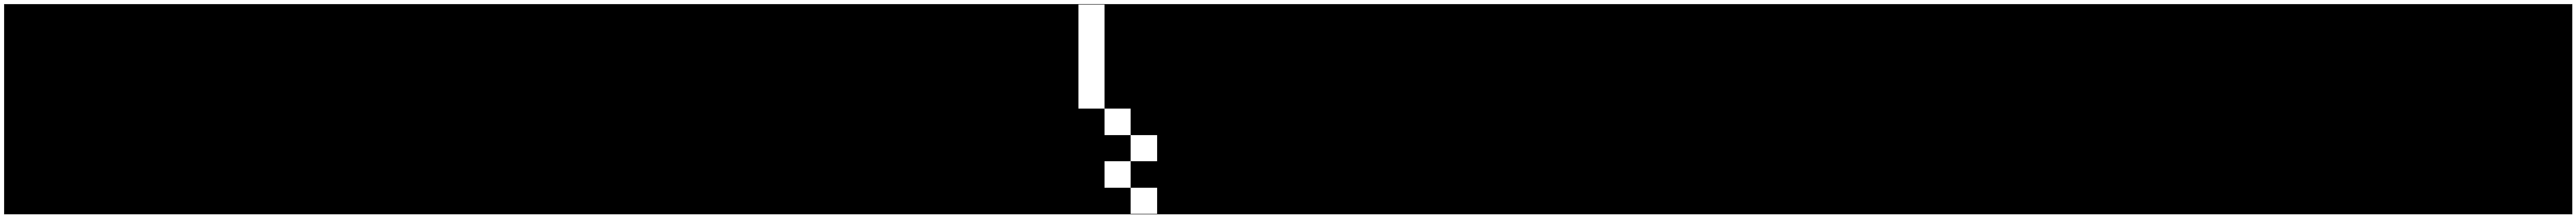

In [ ]:
plot_input(c_df, 1, (layer, n_chann))

Define the fully connected layer for muon/shower classification

In [ ]:
# Extract the encoder part for classification

#fully connected layer which receives the codings from the encoder part
encoded_input = layers.Input(shape=(n_code,))
classifier_output = layers.Dense(1, activation='sigmoid')(encoded_input)
classifier_model = models.Model(encoded_input, classifier_output)

# Compile the classifier model
classifier_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Use the encoder that was trained before to reduce the dimensionality of the input images for train -  validation - test samples

In [ ]:
encoded_x_train= encoder.predict(c_x_train)
encoded_x_validation = encoder.predict(c_x_validation)
encoded_x_test = encoder.predict(c_x_test)

922/922 [==============================] - 3s 3ms/step


Train the classifier layer

In [ ]:
# Train the classifier
classifier_history = classifier_model.fit(x= encoded_x_train, y = c_y_train, epochs=1000, batch_size= 512, validation_data=(encoded_x_validation, c_y_validation), callbacks=[schedule, early_stop])

Epoch 1/1000
404/404 [==============================] - 3s 5ms/step - loss: 0.8658 - accuracy: 0.6984 - val_loss: 0.3998 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 2/1000
404/404 [==============================] - 1s 3ms/step - loss: 0.3020 - accuracy: 0.8948 - val_loss: 0.2361 - val_accuracy: 0.9231 - lr: 9.9990e-04
Epoch 3/1000
404/404 [==============================] - 1s 3ms/step - loss: 0.2018 - accuracy: 0.9357 - val_loss: 0.1749 - val_accuracy: 0.9448 - lr: 9.9980e-04
Epoch 4/1000
404/404 [==============================] - 1s 3ms/step - loss: 0.1600 - accuracy: 0.9503 - val_loss: 0.1471 - val_accuracy: 0.9563 - lr: 9.9970e-04
Epoch 5/1000
404/404 [==============================] - 1s 3ms/step - loss: 0.1385 - accuracy: 0.9578 - val_loss: 0.1287 - val_accuracy: 0.9615 - lr: 9.9960e-04
Epoch 6/1000
404/404 [==============================] - 1s 3ms/step - loss: 0.1260 - accuracy: 0.9621 - val_loss: 0.1215 - val_accuracy: 0.9618 - lr: 9.9950e-04
Epoch 7/1000
404/404 [================

Check the training and validation loss and validation for unsual behaviour

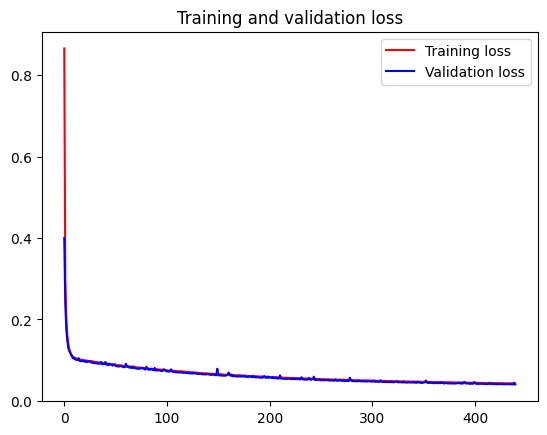

In [ ]:
classifier_loss = classifier_history.history['loss']
classifier_val_loss = classifier_history.history['val_loss']
epochs = range(len(classifier_loss))
plt.figure()
plt.plot(epochs, classifier_loss, 'r', label='Training loss')
plt.plot(epochs, classifier_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

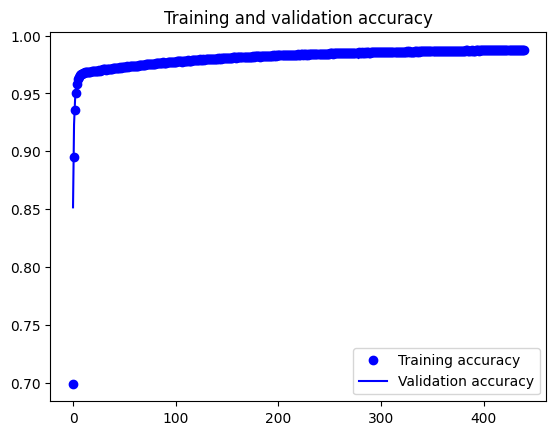

In [ ]:
accuracy = classifier_history.history['accuracy']
val_accuracy = classifier_history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

Save also this model weights

In [ ]:
classifier_model.save_weights('/content/drive/MyDrive/JetDTsAutoencoder/classifier/')

In [ ]:
classifier_model.load_weights('/content/drive/MyDrive/JetDTsAutoencoder/classifier/')

Check the final outpur results using the test sample

In [ ]:
test_eval = classifier_model.evaluate(encoded_x_test, c_y_test)

922/922 [==============================] - 2s 2ms/step - loss: 0.0433 - accuracy: 0.9884


In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.04327608644962311
Test accuracy: 0.988406777381897


Check also the roc curve since it's a classification problem

In [ ]:
from sklearn.metrics import roc_curve
y_pred = classifier_model.predict(encoded_x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(c_y_test, y_pred)

922/922 [==============================] - 2s 2ms/step


In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

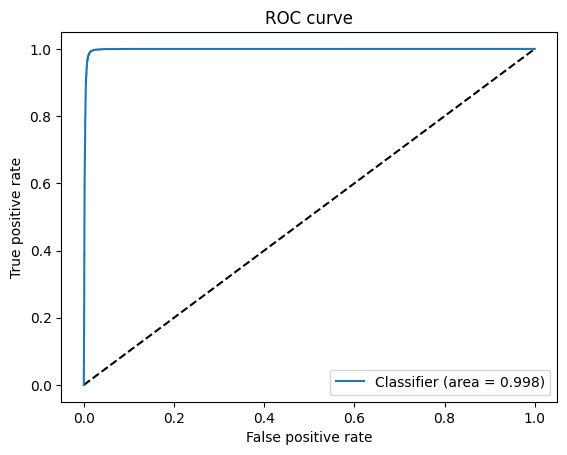

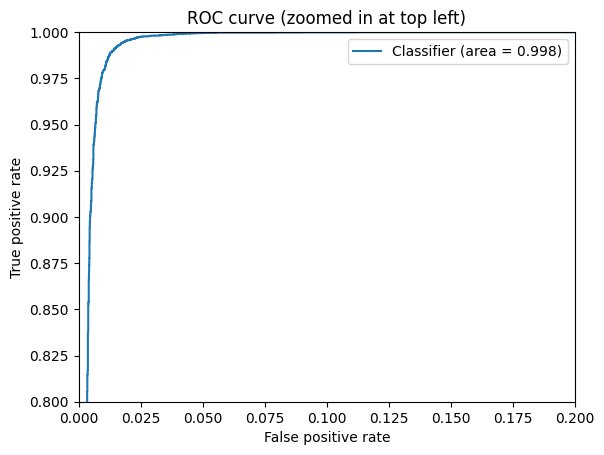

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Classifier (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Classifier (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()